In [11]:
import statistics
import math
from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser, BenchmarkParser
import os

In [12]:
def calculate_average_operations(job_sequence):
    n_jobs = 1
    counts = [1]
    for i in range(1, len(job_sequence)):
        if job_sequence[i] != job_sequence[i-1]:
            n_jobs+=1
            counts.append(0)
        counts[-1] += 1
    return (sum(counts))/n_jobs

def get_max_w(durations):
    max = 0
    for operation in durations:
        for machine in operation:
            for worker in machine:
                if worker > max:
                    max = worker
    return max

def get_max(durations):
    max = 0
    for operation in durations:
        for machine in operation:
        
            if machine > max:
                max = machine
    return max

def worker_flexibility(benchmark):
    n_assignments = 0
    m = benchmark.n_machines()
    o = benchmark.n_operations()
    durations = benchmark.durations()
    combs = dict()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    n_assignments += 1
                combs[(j,k)] = 1
    average_assignments = n_assignments / o
    return average_assignments / len(combs)

def flexibility(benchmark):
    n_assignments = 0
    m = benchmark.n_machines()
    o = benchmark.n_operations()
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            if durations[i][j] > 0:
                n_assignments += 1
    average_assignments = n_assignments / o
    return average_assignments / n_assignments

def get_flexibility_and_dv_worker(benchmark):
    all = 0
    unique = []
    machines_available = 0
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    if durations[i][j][k] not in unique:
                        unique.append(durations[i][j][k])
                    all += 1
            if any([x > 0 for x in durations[i][j]]):
                machines_available+=1
    return worker_flexibility(benchmark), len(unique) / all

def get_flexibility_and_dv(benchmark):
    all = 0
    unique = []
    machines_available = 0
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            if durations[i][j] > 0:
                if durations[i][j] not in unique:
                    unique.append(durations[i][j])
                all += 1
        if any([x > 0 for x in durations[i]]):
            machines_available+=1
    return flexibility(benchmark), len(unique) / all

def calculate_duration_features_workers(durations):
    all_durations = []
    for duration in durations:
        for d in duration:
            all_durations.extend(d)
    all_durations = [int(d) for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    stdev = statistics.stdev(all_durations)
    return min_duration, max_duration, span, stdev

def calculate_duration_features(durations):
    all_durations = []
    for duration in durations:
        all_durations.extend(duration)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    #stdev = statistics.stdev(all_durations)
    mean = sum(all_durations)/len(all_durations)
    var = sum(pow(x-mean, 2) for x in all_durations) / len(all_durations)
    stdev = math.sqrt(var)
    return min_duration, max_duration, span, stdev


In [16]:
def remap_full(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[1].startswith('Behnke'):
        return 'BehnkeGeiger'+values[-1]
    if values[1].startswith('Brandimarte'):
        return 'Brandimarte'+values[-1]
    if values[1].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('s'):
        return 'HurinkSdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('e'):
        return 'HurinkEdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('r'):
        return 'HurinkRdata'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('v'):
        return 'HurinkVdata'+values[-1]
    if values[1].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[1].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[1].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name.lower()

In [ ]:
path = r'C:\Users\huda\Downloads\paper_results\paper_results\benchmarks_with_workers'
parser = WorkerBenchmarkParser()

instances = os.listdir(path)
instance_data = dict()
consider_duration_features = True
for instance in instances:
    encoding = parser.parse_benchmark(path + "\\" + instance)
    feature_vector = []
    min_d, max_d, d_span, d_stdev = calculate_duration_features_workers(encoding.durations())
    #TODO: worker data, or just do it with base FJSSP since all benchmarks are transformed in the same way
    f, dv = get_flexibility_and_dv_worker(encoding)
    extracted_data = {
        "name": remap_full(instance),
        "n_jobs": encoding.n_jobs(), 
        "n_machines": encoding.n_machines(),
        "n_operations": encoding.n_operations(),
        "durations": encoding.durations(),
        "job_sequence": encoding.job_sequence(),
        "machines_for_all_operations": encoding.get_all_machines_for_all_operations(),
        "flexibility": f,
        "duration_variety": dv,
        "average_operations": calculate_average_operations(encoding.job_sequence()),
        "min_duration": min_d,
        "max_duration": max_d,
        "duration_span": d_span,
        "duration_std": d_stdev
    }
    instance_data[remap_full(instance[:-12])] = extracted_data

In [18]:
instance_data.keys()

dict_keys(['BehnkeGeiger10', 'BehnkeGeiger11', 'BehnkeGeiger12', 'BehnkeGeiger13', 'BehnkeGeiger14', 'BehnkeGeiger15', 'BehnkeGeiger16', 'BehnkeGeiger17', 'BehnkeGeiger18', 'BehnkeGeiger19', 'BehnkeGeiger1', 'BehnkeGeiger20', 'BehnkeGeiger21', 'BehnkeGeiger22', 'BehnkeGeiger23', 'BehnkeGeiger24', 'BehnkeGeiger25', 'BehnkeGeiger26', 'BehnkeGeiger27', 'BehnkeGeiger28', 'BehnkeGeiger29', 'BehnkeGeiger2', 'BehnkeGeiger30', 'BehnkeGeiger31', 'BehnkeGeiger32', 'BehnkeGeiger33', 'BehnkeGeiger34', 'BehnkeGeiger35', 'BehnkeGeiger36', 'BehnkeGeiger37', 'BehnkeGeiger38', 'BehnkeGeiger39', 'BehnkeGeiger3', 'BehnkeGeiger40', 'BehnkeGeiger41', 'BehnkeGeiger42', 'BehnkeGeiger43', 'BehnkeGeiger44', 'BehnkeGeiger45', 'BehnkeGeiger46', 'BehnkeGeiger47', 'BehnkeGeiger48', 'BehnkeGeiger49', 'BehnkeGeiger4', 'BehnkeGeiger50', 'BehnkeGeiger51', 'BehnkeGeiger52', 'BehnkeGeiger53', 'BehnkeGeiger54', 'BehnkeGeiger55', 'BehnkeGeiger56', 'BehnkeGeiger57', 'BehnkeGeiger58', 'BehnkeGeiger59', 'BehnkeGeiger5', 'Beh

In [81]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.numpoints'] = 1

colors = {
    'BehnkeGeiger': 'blue',
    'Brandimarte': 'green',
    'ChambersBarnes': 'red',
    'HurinkSdata': 'teal',
    'HurinkEdata': 'orange',
    'HurinkRdata': 'purple',
    'HurinkVdata': 'crimson',
    'DPpaulli': 'brown',
    'Kacem': 'silver',
    'Fattahi': 'darkcyan',

}
markers = {
    'BehnkeGeiger': '^',
    'Brandimarte': 'v',
    'ChambersBarnes': 'x',
    'HurinkSdata': '>',
    'HurinkEdata': '<',
    'HurinkRdata': 'o',
    'HurinkVdata': 'p',
    'DPpaulli': 'd',
    'Kacem': '1',
    'Fattahi': '2'
}
markerson = 0.1

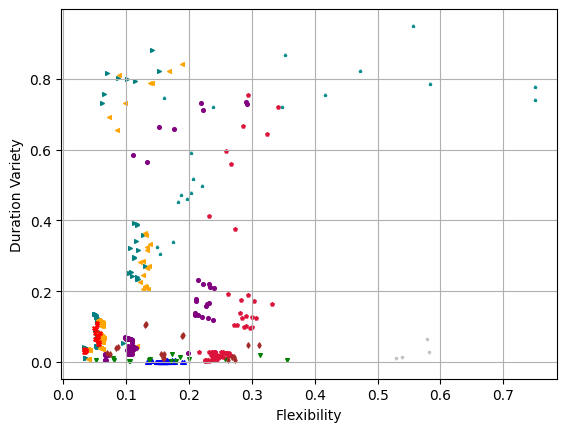

In [35]:
for instance in instance_data:
    stripped = ''.join([i for i in instance if not i.isdigit()])
    plt.scatter(instance_data[instance]['flexibility'], instance_data[instance]['duration_variety'], marker=markers[stripped], c=colors[stripped], s=7)
plt.xlabel('Flexibility')
plt.ylabel('Duration Variety')
plt.show()

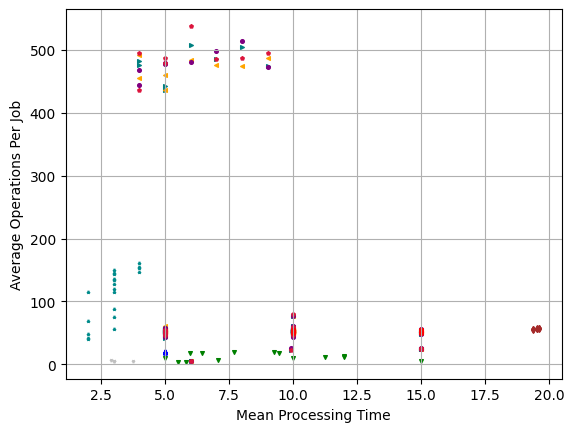

In [36]:
def average_duration(durations):
    count = 0.0
    result = 0.0
    for operation in durations:
        for machine in operation:
            for worker in machine:
                if worker > 0:
                    result+=worker
                    count+=1.0
    return result/count

for instance in instance_data:
    stripped = ''.join([i for i in instance if not i.isdigit()])
    plt.scatter(instance_data[instance]['average_operations'], average_duration(instance_data[instance]['durations']), marker=markers[stripped], c=colors[stripped], s=7)
plt.xlabel('Mean Processing Time')
plt.ylabel('Average Operations Per Job')
plt.show()

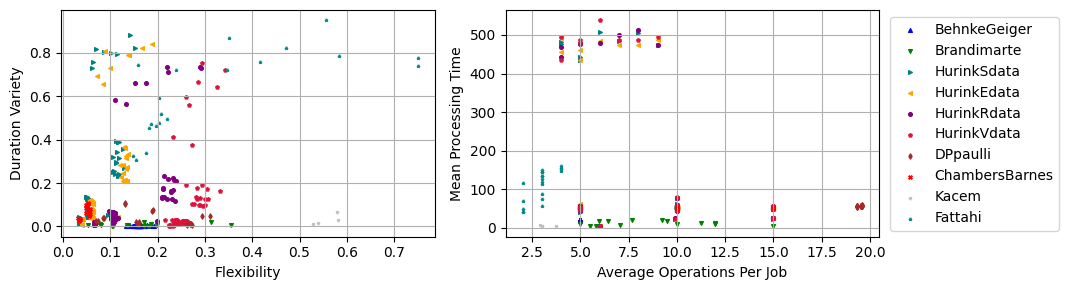

In [87]:
fig = plt.figure(layout='tight', figsize=(9, 3))
axs = fig.subplots(1, 2)
labels = []
for instance in instance_data:
    stripped = ''.join([i for i in instance if not i.isdigit()])
    axs[0].scatter(instance_data[instance]['flexibility'], instance_data[instance]['duration_variety'], marker=markers[stripped], c=colors[stripped], s=7, label=stripped if stripped not in labels else '')
    if stripped not in labels:
        labels.append(stripped)
    axs[1].scatter(instance_data[instance]['average_operations'], average_duration(instance_data[instance]['durations']), marker=markers[stripped], c=colors[stripped], s=7)
axs[1].set_xlabel('Average Operations Per Job')
axs[1].set_ylabel('Mean Processing Time')
axs[0].set_xlabel('Flexibility')
axs[0].set_ylabel('Duration Variety')

#from matplotlib.lines import Line2D
#legend_elements = [Line2D([],[], color=colors[label], marker=markers[label], label=label, linestyle=None) for label in labels]

#fig.legend(handles=legend_elements, loc='outside upper center', bbox_to_anchor=(0.5, 1.1), ncols=5)
#fig.legend(handles=legend_elements, loc='outside right', bbox_to_anchor=(1.19, 0.57))
fig.legend(loc='outside right', bbox_to_anchor=(1.19, 0.57))
plt.show()